<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Frequentist and Bayesian A/B Testing

_Authors: Kiefer Katovich (SF), Joseph Nelson (DC)_

---

### Learning Objectives
- Review the Frequentist methods for statistical testing
- Write a function to perform a z-test for an A/B test
- Understand how to evaluate a split test with Bayesian methods
- Use pymc3 to evaluate a split test with 2 arms
- Use pymc3 to evaluate a split test with 3 arms
- Compare pymc3 and sampling from beta distributions for evaluating split test results

### Lesson Guide
- [A/B tests (split tests)](#ab-tests)
- [Frequentist A/B test evaluation](#frequentist)
    - [Z-test function to evaluate an A/B test](#st-func)
- [Bayesian split test analysis](#bayes)
- [Load the fitness app data](#data)
    - [Examine the split test arm "schedule"](#schedule)
- [Model conversion rates through day 5 with `pymc3`](#day5)
    - [Set up a `pymc3` model with uniform priors for the probabilities of conversion for arms A and B](#day5-model)
    - [Set up `pm.Bernoulli` distributions to model conversions for arms A and B](#day5-bernoulli)
    - [Fit the model](#day5-fit)
- [Independent practice: build a `pymc3` model through day 11 for the A/B/C test](#ind-practice)
- [Sample from beta distributions to evaluate the split test](#beta)
    - [Create beta distributions representing the conversions vs. failures for each arm for *all* days](#bdists)
    - [Calculate AvB, AvC, and BvC using sampling from the beta distributions](#beta-sampling)
    - [Validate that these reults are the same as a `pymc3` model](#beta-vs-pymc3)
- [Additional resources](#resources)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

sns.set_style('whitegrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

<a id='ab-tests'></a>
## A/B tests (split tests)
---

For every product you use (espcially tech products) it is likely that you are part of a split test. Split tests are incrementally different versions of a product that are being tested on randomly selected users and evaluated on a performance metric. They are a great way to assess whether a proposed change will be beneficial, detrimental, or have no effect.

<a id='frequentist'></a>
## Frequentist A/B test evaluation
---

The t-test is a classic Frequentist test for a significant difference in means between groups.

Below we can generate some fake data and perform a t-test for the difference in means.

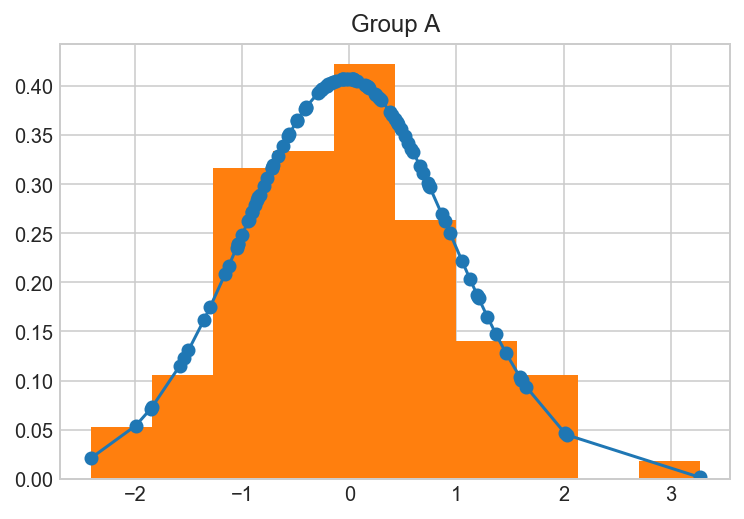

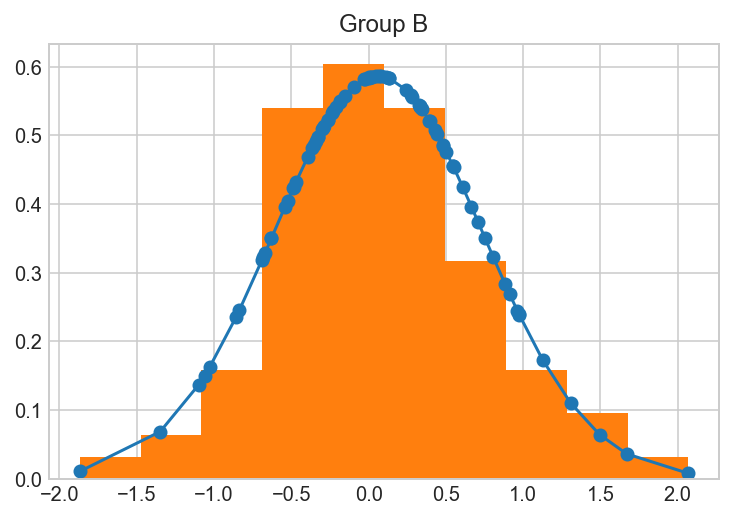

Ttest_indResult(statistic=-0.68700723965076116, pvalue=0.49297224622836988)


In [2]:
# Generate data
a = sorted(np.random.randn(100))
b = sorted(np.random.randn(1) * np.random.randn(80))

# Plot distribution of A
fit = stats.norm.pdf(a, np.mean(a), np.std(a))
plt.plot(a, fit,'-o')
plt.hist(a, normed=True) 
plt.title('Group A')
plt.show()

# Plot distribution of B
fit = stats.norm.pdf(b, np.mean(b), np.std(b))
plt.plot(b, fit,'-o')
plt.hist(b, normed=True) 
plt.title('Group B')
plt.show()

# Perform T-test
print stats.ttest_ind(a, b)


<a id='st-func'></a>
### Z-test function to evaluate an A/B test

In split tests (A/B tests) we successes and failures for each "arm". We are interested in calculating whether the mean difference in rates between the two arms is significantly different. If it is, then we have reason to "winner" the arm of the test that has a higher conversion rate.

Below we can write a function to manually perform a z-test given successes out of a certain number of observations for each of our two arms. We can test it out on some fake data:

In [3]:
# null hypothesis: the samples have identical averages
# if p < 0.05, reject null hypothesis that the two samples are identical

# ztest
def ztest(x1, n1, x2, n2, one_tailed=False):
    """
    One- or Two-Tailed Z-test for two samples
    
    Args:
        x1 = # of successes in Sample 1
        n1 = # of observations in Sample 1
        x2 = # of successes in Sample 2
        n2 = # of observations in Sample 2
        one_tailed = Boolean, whether or not the test should be One-Tailed
        
    Return:
        z = Z-stat
    """
    p1 = float(x1) / n1
    p2 = float(x2) / n2    
 
    p = float(x1 + x2) / (n1 + n2)
    se = p * (1. - p) * ((1. / n1) + (1. / n2))
    sse = np.sqrt(se)
    
    z = float(p1 - p2) / sse
    p = 1 - stats.norm.cdf(abs(z))
    
    if not one_tailed:
        p *= 2.
    print z, p
    return z, p

# Do a test with fake data:

control_observations = 3141 #n1
control_successes = 1904 # x1
test_observations = 3241 #n2
test_successes = 2134 #x2

ztest(control_successes, control_observations, test_successes, test_observations, one_tailed=False)

-4.32991207154 1.49168891623e-05


(-4.3299120715441166, 1.4916889162330804e-05)

<a id='bayes'></a>
## Bayesian split test analysis
---

One common application of Bayesian analysis in industry is the analysis of split tests. We can use `pymc3` to perform split test analysis or do the process manually by sampling from posterior distributions for the arm conversion rates. 

<a id='data'></a>
## Load the fitness app data
---

The dataset below contains information on user "conversions" on a fitness app on different "arms" of a split test. 

[A "conversion"](https://en.wikipedia.org/wiki/Conversion_marketing) is jargon for whether or not a user performed a desired action or not, typically a purchase.

"Arms" are the jargon for the different versions of a product in a currently running split test. Split tests are also commonly referred to as [A/B tests](https://en.wikipedia.org/wiki/A/B_testing), where A and B denote arms in the test.

**The data has 6 columns:**

    arm: the version of the app this user was randomly assigned to
    gender: male/female
    age: age bins, one of 20-30, 30-40, 40-50
    day: the day (total of 21 days)
    fitness: the user's self reported fitness level from -5 to 5
    converted: 1 if the user purchased the product, 0 if not
    
Each row is a unique user. 

In [4]:
data = pd.read_csv('../datasets/split_test_data.csv')
data['male'] = data.gender.map(lambda x: 1 if x == 'male' else 0)

<a id='schedule'></a>
### Examine the split test arm schedule

When a new arm is introduced into a split test, it is generally tested at a low percentage of users initially before assignment becomes balanced between the arms. This ensures that if something is terribly wrong with one of the arms it does not ruin the experience for too many potential customers.

Find the counts assigned to each split test arm by day.

In [5]:
print data.shape
data.head()

(725, 7)


,arm,gender,age,day,fitness,converted,male
0,A,female,20-30,0,-2.0,0,0
1,A,female,40-50,0,3.0,0,0
2,A,female,30-40,0,-5.0,0,0
3,A,female,20-30,0,-4.0,0,0
4,A,male,30-40,0,1.0,1,1


In [6]:
arms_days = data[['arm','day']]
arms_days.groupby('day')['arm'].value_counts()

day  arm
0    A      26
1    A      40
     B       4
2    A      30
     B       3
3    A      30
     B       3
4    A      18
     B      18
5    A      15
     B      15
6    A      16
     B      16
7    A      17
     B      17
8    A      14
     B      14
     C       3
9    A      19
     B      19
     C       4
10   A      12
     B      12
     C       3
11   A       9
     B       9
     C       9
12   A      10
     B      10
     C      10
13   A      15
     B      15
     C      15
14   A      12
     B      12
     C      12
15   A      12
     B      12
     C      12
16   A      11
     B      11
     C      11
17   A      11
     B      11
     C      11
18   A      14
     B      14
     C      14
19   A      12
     B      12
     C      12
20   A      13
     B      13
     C      13
Name: arm, dtype: int64

**Look at mean conversion rate overall and by arm.**

In [7]:
data.converted.mean()

0.17517241379310344

In [8]:
data.groupby('arm')['converted'].agg(np.mean)

arm
A    0.185393
B    0.116667
C    0.255814
Name: converted, dtype: float64

**Look at overall conversion rate differences along age, gender, and fitness.**

In [9]:
data.groupby('age')['converted'].agg(np.mean)

age
20-30    0.253112
30-40    0.155738
40-50    0.116667
Name: converted, dtype: float64

In [10]:
data.groupby('gender')['converted'].agg(np.mean)

gender
female    0.206897
male      0.145889
Name: converted, dtype: float64

In [11]:
data.groupby('fitness')['converted'].agg(np.mean)

fitness
-5.0    0.055556
-4.0    0.026316
-3.0    0.073171
-2.0    0.148649
-1.0    0.086957
 0.0    0.179487
 1.0    0.161290
 2.0    0.171053
 3.0    0.276923
 4.0    0.391892
 5.0    0.484848
Name: converted, dtype: float64

In [12]:
data.arm.value_counts()

A    356
B    240
C    129
Name: arm, dtype: int64

<a id='day5'></a>
## Model conversion rates through day 5 with `pymc3`
---

We will start by just modeling the conversion rate distributions for arms A and B through day 5. At day 5, arm C has still not been introduced yet and so there are just 2 arms.

**Subset the data to the first 5 days**

In [14]:
import pymc3 as pm

In [15]:
current = data[data.day < 5]
print current.shape, current.arm.unique()
print current.groupby('arm')['converted'].agg(np.sum)

(172, 7) ['A' 'B']
arm
A    26
B     3
Name: converted, dtype: int64


<a id='day5-model'></a>
### Set up a `pymc3` model and uniform priors for the probabilities of conversion for arms A and B

Recall that `pymc3` uses the `with ...` syntax for defining models. The first step in setting up a new model is to define the model as the "context" like so:

>```python
with pm.Model() as day5_model:
    #
```

We are going to model the _probability distributions for conversion rates for arms A and B._ As always with Bayesian statistics, we need to define prior distributions for our belief about these probabilities/rates of conversion per arm.

Let's say we have no belief whatsoever about rates, and so we will set an uninformative, flat priors over probabilities from 0 to 1 for both arms. This is equivalent to saying that we believe all conversion rates to be equally likely for both arms.

The syntax for setting up this flat prior is:

>```python
arm_A_prior = pm.Uniform('A_prior', lower=0, upper=1)
```

Set up the priors for both arms inside the `with ...` model block.

In [16]:
with pm.Model() as day5_model:
    
    A_p = pm.Uniform('A_prob', lower=0, upper=1)
    B_p = pm.Uniform('B_prob', lower=0, upper=1)

<a id='day5-bernoulli'></a>
### Set up `pm.Bernoulli` distributions to model conversions for arms A and B

Now that you've initialized your model, your `with` statements will be

>```python
with day5_model:
    #
```

Be careful not to re-define the model with `pm.Model()` or it will wipe the uniform priors you set before!

We are now going to set up the "likelihood" portion of the model. This is going to model the $P(data\;|\;\theta)$ part of Bayes theorem.

Our conversions are represented by a vector of 1s and 0s denoting whether or not the user converted or not. This is known as a "Bernoulli" process and pymc3 has an approprite function to handle it:

>```python
A_conversions = pm.Bernoulli('A_conversions', p=arm_A_prior, observed=arm_A_conversions)
```

`p=` is set to the prior for the arm that you defined in the last section. 

`observed=` should be set to the `converted` values for that arm specifically in the data.

By giving it an `observed` parameter, we are telling pymc3 that we want this to evaluate the likelihood of our data (the conversions) against models represented by the `p=` probability argument. We assign `p=` to be our prior belief about conversion rates for that arm because we want to update this belief (convert to posterior) based on the conversion data we have observed for that arm.

In [18]:
with day5_model:
    
    A = pm.Bernoulli('A', p=A_p, observed=current[current.arm == "A"].converted.values)
    B = pm.Bernoulli('B', p=B_p, observed=current[current.arm == "B"].converted.values) 
    
    AvB = pm.Deterministic('AvB', A_p - B_p)

<a id='day5-fit'></a>
### Fit the model

Now that we've set up the prior distributions and likelihoods, we can actually fit the model.

Below is code that will run the sampling procedure to find the posteriors:

>```python
with day5_model:
    # obtain decent starting values via the find_MAP() function:
    start = pm.find_MAP()
    # construct the "trace" variable that holds samples for all of our distributions:
    trace = pm.sample(50000, start=start)
```

Again you use the context `with day5_model:` to run code for your model.

`start = pm.find_MAP()` will try to find a good starting point for the sampling process. This means that your model will converge on the "likely" area much faster (though it makes the fitting slower initially).

`trace = pm.sample(50000, start=start)` uses the sampling method in `pymc3` to perform 50,000 sampling iterations. This will automatically assign the NUTS sampler for you. The dataset is small so the speed shouldn't be too bad.

When this completes, the `trace` variable now contains the posterior samples for the distributions we specified while constructing the model.

>```python
# We defined our arm A prior distribution to be uniform and named it 'arm_A_prior'. 
# The pm.sample() procedure converted this into our posterior belief for the rate
# of conversions in arm A. You can access these posterior samples using the name
# you gave the variable when you created it:
#
trace['arm_A_prior']
#
# this will be a vector of values that are different potential rates of conversion
# for arm A. A histogram of these rates defines, roughly, the posterior probability
# distribution for the arm A rates after we consider the data we have collected.
```

In [19]:
with day5_model:
    start = pm.find_MAP()
    trace = pm.sample(50000, start=start)

logp = -119.22, ||grad|| = 47.297: 100%|██████████| 11/11 [00:00<00:00, 1012.52it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 50500/50500 [00:24<00:00, 2081.63it/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x10a5abb10>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1c130cd250>], dtype=object)

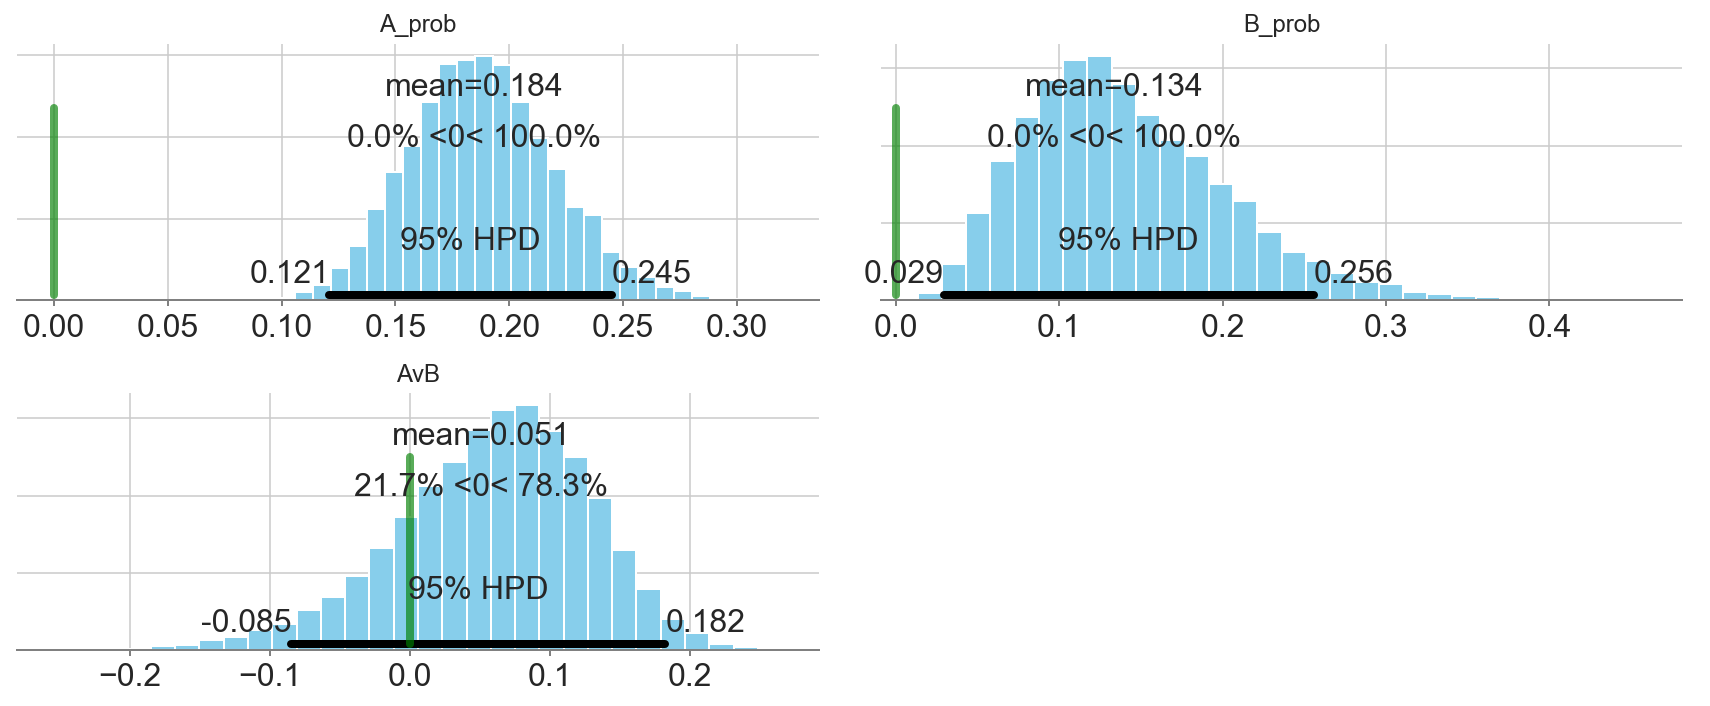

In [20]:
pm.plot_posterior(trace[5000::3], varnames=['A_prob','B_prob','AvB'],
                  ref_val=0, color='#87ceeb')

<a id='ind'></a>
## Independent practice: build a model through day 11 for an A/B/C test
---

Subset the data up through day 11. You will notice now that there are 3 different arms: A, B, and C.

You will need to add in the third arm into the model.

Additionally, calculate 3 "deterministic" variables that look at differences between the three arms:

- `A` vs. `B`
- `A` vs. `C`
- `B` vs. `C`

What action would you take given these results?

In [21]:
current = data[data.day < 11]
print current.shape, current.arm.unique()

(368, 7) ['A' 'B' 'C']


In [22]:
with pm.Model() as day11_model:
    
    A_p = pm.Uniform('A_prob', lower=0, upper=1)
    B_p = pm.Uniform('B_prob', lower=0, upper=1)
    C_p = pm.Uniform('C_prob', lower=0, upper=1)
    
    A = pm.Bernoulli('A', p=A_p, observed=current[current.arm == 'A'].converted.values)
    B = pm.Bernoulli('B', p=B_p, observed=current[current.arm == 'B'].converted.values)
    C = pm.Bernoulli('C', p=C_p, observed=current[current.arm == 'C'].converted.values)
    
    AvB = pm.Deterministic('AvB', A_p - B_p)
    AvC = pm.Deterministic('AvC', A_p - C_p)
    BvC = pm.Deterministic('BvC', B_p - C_p)
    
    start = pm.find_MAP()
    trace = pm.sample(50000, start=start)
    

logp = -158.51, ||grad|| = 0.006491: 100%|██████████| 14/14 [00:00<00:00, 2012.90it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 50500/50500 [00:30<00:00, 1634.66it/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c13409990>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1c157eb150>], dtype=object)

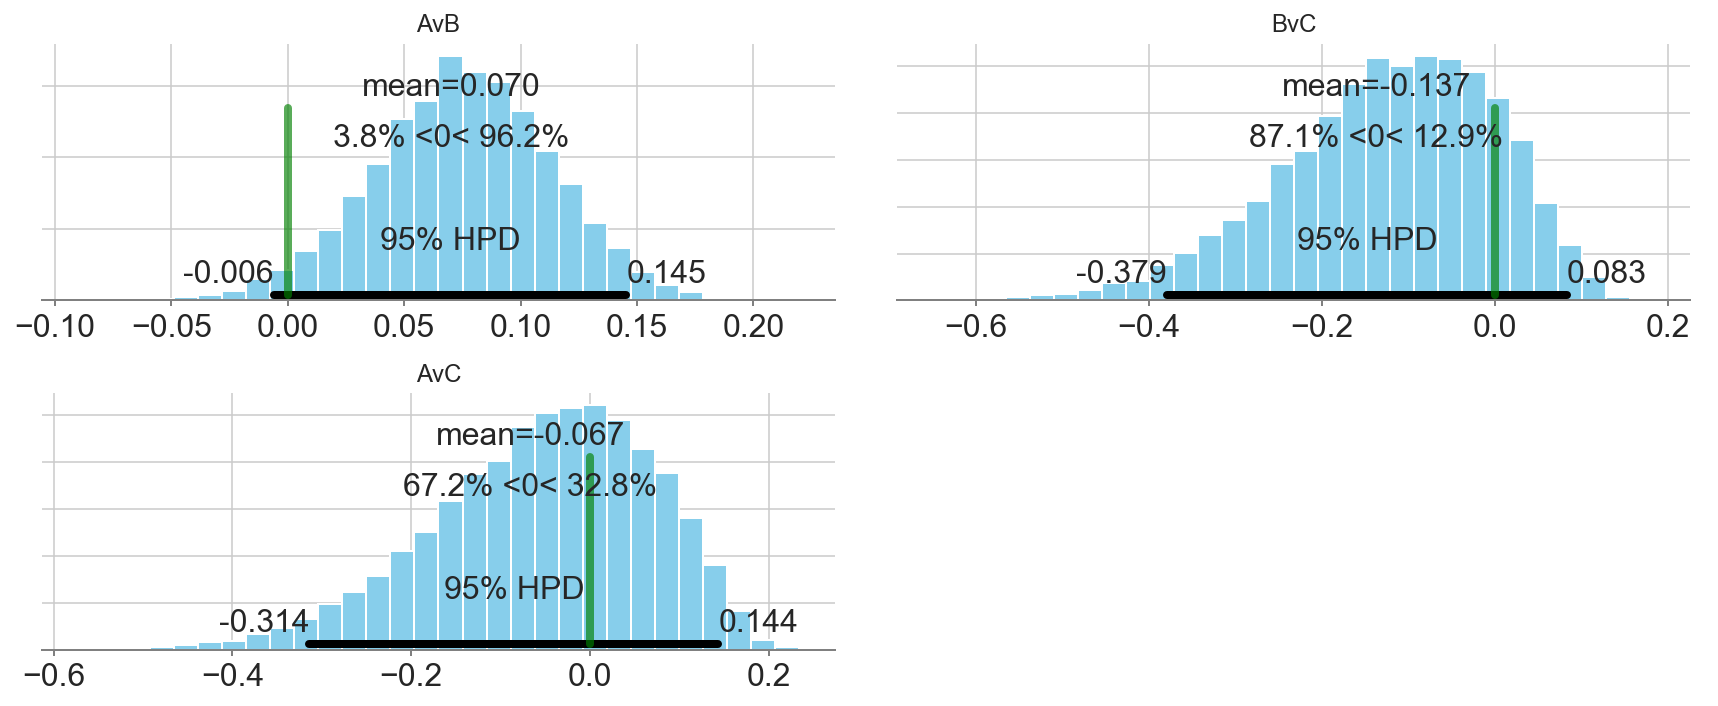

In [23]:
pm.plot_posterior(trace[5000::3], varnames=['AvB','BvC','AvC'], color='#87ceeb', ref_val=0.)

In [24]:
def plot_betas(beta_traces, beta_names, colors=['steelblue','darkred','goldenrod']):
    fig, ax = plt.subplots(figsize=(9,5))
    for i, bn in enumerate(beta_names):
        ax = sns.distplot(beta_traces[i], kde=True, color=colors[i], label=bn)
    ax.legend(loc='upper right')
    plt.show()

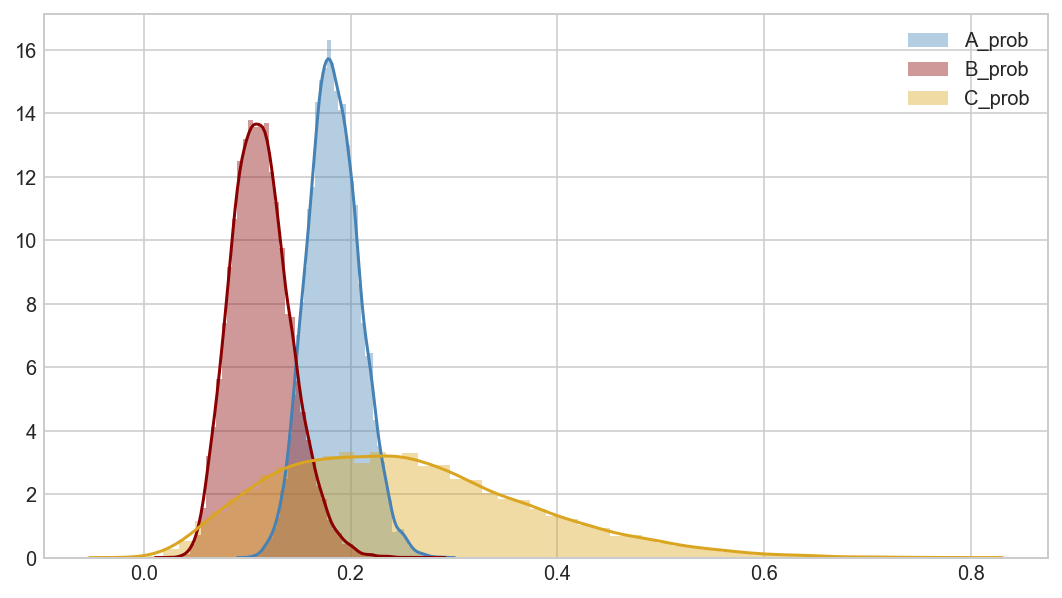

In [25]:
plot_betas([trace[5000::3]['A_prob'], 
            trace[5000::3]['B_prob'],
            trace[5000::3]['C_prob']],
           ['A_prob','B_prob','C_prob'])

In [26]:
# We can be fairly certain that arm A has a higher conversion rate than arm B.
# There is not enough data to make a statement about arm C.

<a id='beta'></a>
## Sample from beta distributions to evaluate the split test
---

Our arms are represented as Bernoulli distributed random variables (binary outcome conversion vs. failure). Our prior distributions model the probability of different rates for the arms. 

> **Note:** a uniform distribution between 0 and 1 is equivalent to a Beta(1,1), or in other words a Beta distribution with 0 successes and 0 failures.

We know that the Beta distribution is a conjugate prior to the binomial likelihood, and therefore the posterior distributions for our arms are also beta distributions.

<a id='bdists'></a>
### Create beta distributions representing the conversions vs. failures for each arm for *all* days.

The beta distributions will be parameterized with alpha and beta, which are equivalent to successes + 1 and failures + 1 respectively.

In [27]:
data.groupby('arm')['converted'].agg([sum, len])

,sum,len
arm,,
A,66,356
B,28,240
C,33,129


In [36]:
a_beta = stats.beta(67, 356-66)
b_beta = stats.beta(29, 240-28)
c_beta = stats.beta(34, 129-33)

**Plot the beta distributions across the 0-0.4 range of rates.**

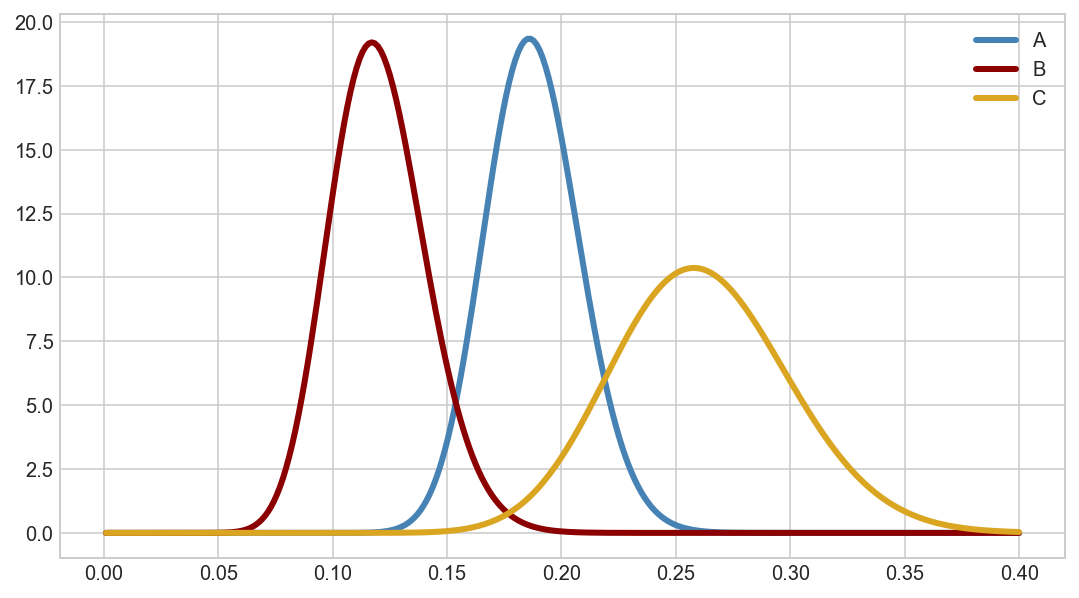

In [37]:
fig, ax = plt.subplots(figsize=(9,5))
rates = np.linspace(0.001, 0.40, 300)
ax.plot(rates, a_beta.pdf(rates), color='steelblue', lw=3, label='A')
ax.plot(rates, b_beta.pdf(rates), color='darkred', lw=3, label='B')
ax.plot(rates, c_beta.pdf(rates), color='goldenrod', lw=3, label='C')
ax.legend(loc='upper right')
plt.show()

<a id='beta-sampling'></a>
### Calculate AvB, AvC, and BvC using sampling from the beta distribution

The beta distributions for the arm are our posterior distributions for the conversion rate of each arm given the observed data.

We can calculate the distributions of differences in rates between the arms using sampling. The procedure is:
1. Set up a certain number of iterations (1000, for example)
2. For each iteration, take a random draw from each beta distribution
3. Calculate the difference between the sampled rates between the arms
4. Store the differences in lists

Then you can plot these distributions of differences.

In [38]:
a_samples = a_beta.rvs(5000)
b_samples = b_beta.rvs(5000)
c_samples = c_beta.rvs(5000)

AvB = a_samples-b_samples
AvC = a_samples-c_samples
BvC = b_samples-c_samples

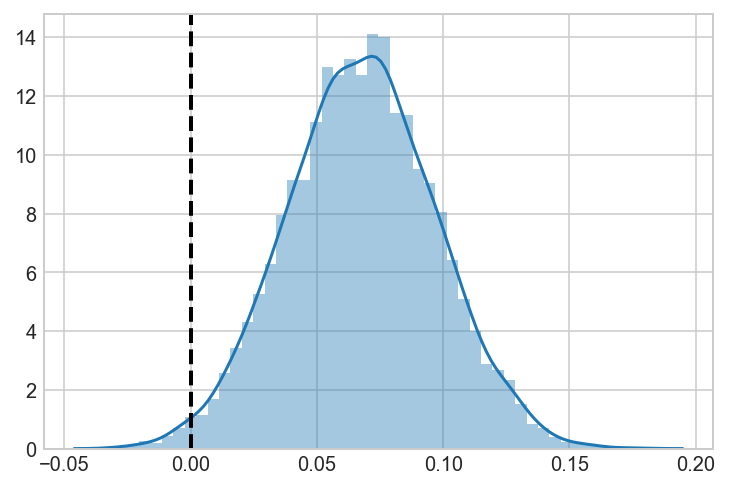

In [39]:
ax = sns.distplot(AvB)
ax.axvline(0, lw=2, ls='dashed', c='black')

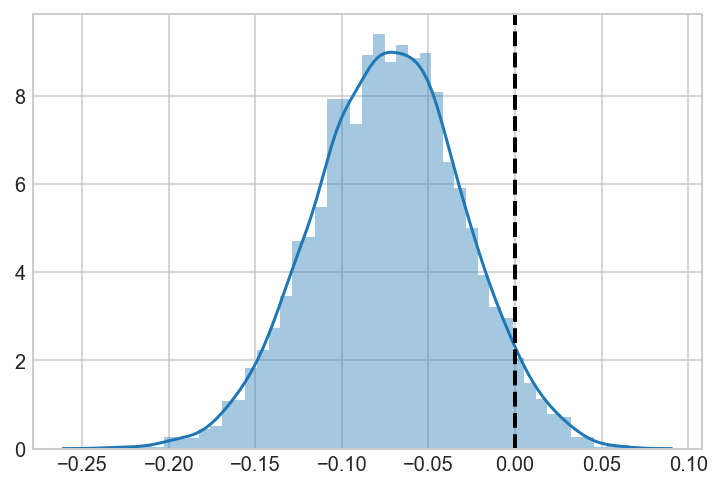

In [40]:
ax = sns.distplot(AvC)
ax.axvline(0, lw=2, ls='dashed', c='black')

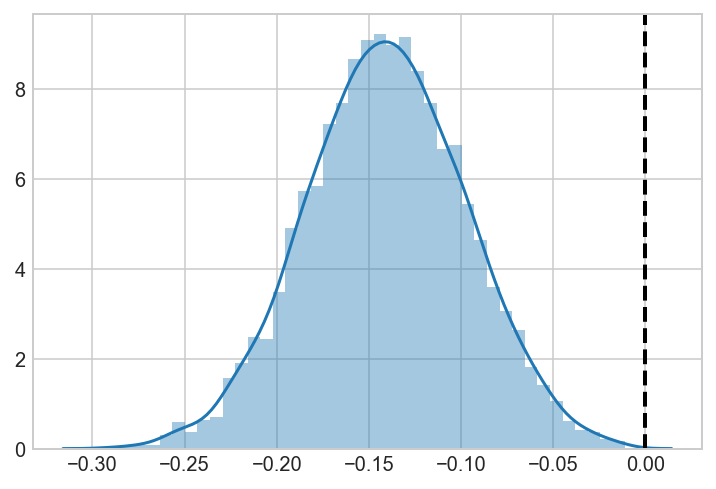

In [41]:
ax = sns.distplot(BvC)
ax.axvline(0, lw=2, ls='dashed', c='black')

<a id='beta-vs-pymc3'></a>
### Validate that these results are the same as a `pymc3` model

You can just take the model you built for day 11 and adjust it to use all the days. Plot the posterior distributions and validate that the results are (almost) the same as you get from sampling from the beta distributions.

In [42]:
with pm.Model() as all_days_model:
    
    A_p = pm.Uniform('A_prob', lower=0, upper=1)
    B_p = pm.Uniform('B_prob', lower=0, upper=1)
    C_p = pm.Uniform('C_prob', lower=0, upper=1)
    
    A = pm.Bernoulli('A', p=A_p, observed=data[data.arm == 'A'].converted.values)
    B = pm.Bernoulli('B', p=B_p, observed=data[data.arm == 'B'].converted.values)
    C = pm.Bernoulli('C', p=C_p, observed=data[data.arm == 'C'].converted.values)
    
    AvB = pm.Deterministic('AvB', A_p - B_p)
    AvC = pm.Deterministic('AvC', A_p - C_p)
    BvC = pm.Deterministic('BvC', B_p - C_p)
    
    start = pm.find_MAP()
    trace = pm.sample(50000, start=start)
    

logp = -502.53, ||grad|| = 148.32: 100%|██████████| 10/10 [00:00<00:00, 1248.56it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 50500/50500 [00:32<00:00, 1533.56it/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c19ca4250>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1c19bcce90>], dtype=object)

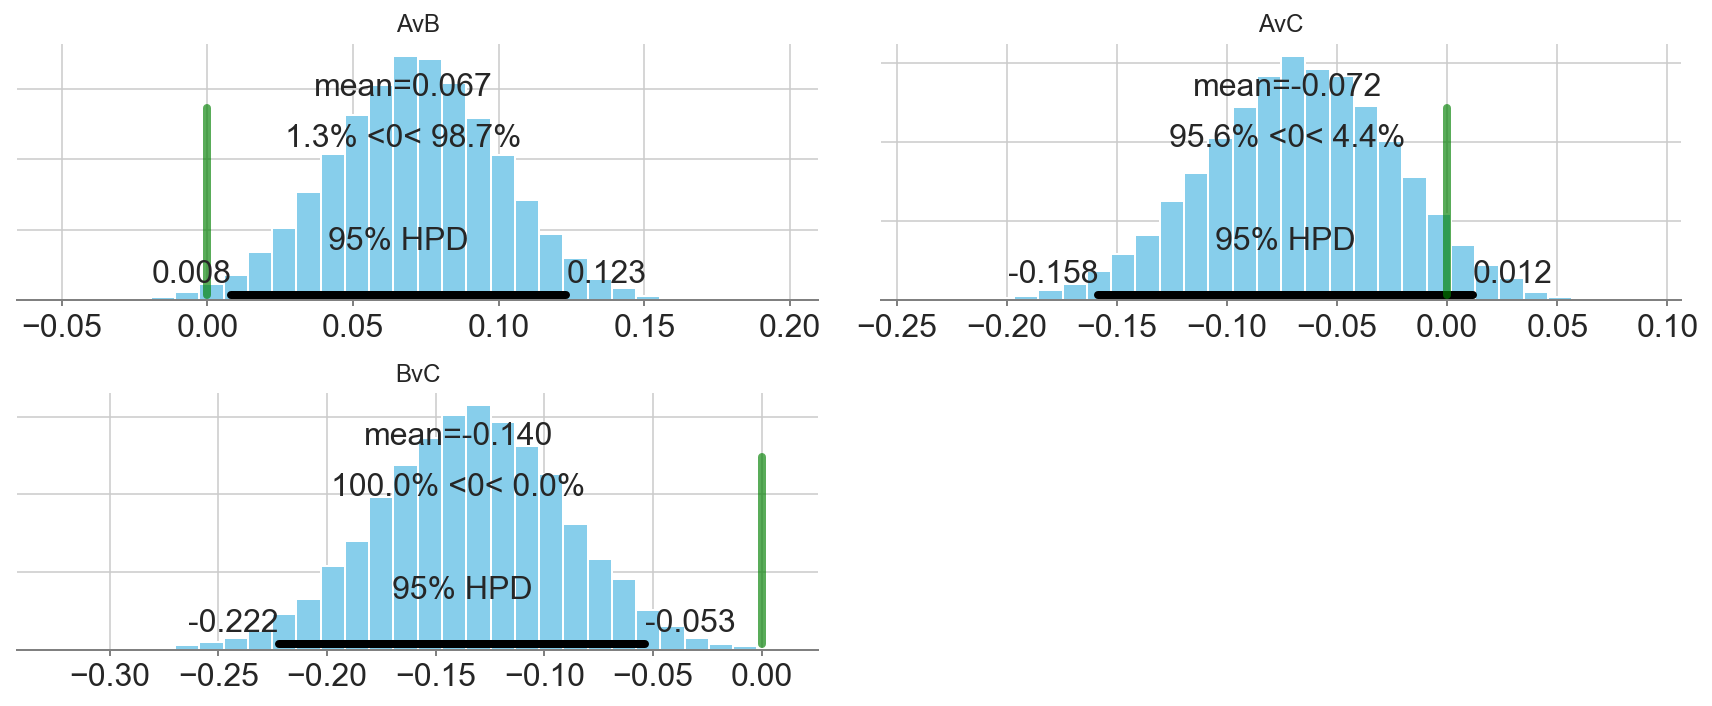

In [43]:
pm.plot_posterior(trace[5000::3], varnames=['AvB','AvC','BvC'], color='#87ceeb', ref_val=0.)

<a id='resources'></a>
## Additional resources
---
+ [Obama Fundraising](https://blog.optimizely.com/2010/11/29/how-obama-raised-60-million-by-running-a-simple-experiment/) example
+ [Social Media Marketing](https://vwo.com/blog/amd-3600-social-sharing-increase) example
+ [Google Multi-Armed Bandit](https://support.google.com/analytics/answer/2844870?hl=en) explanation
+ [Designing an AB Test](http://www.win-vector.com/blog/2015/06/designing-ab-tests/)
+ [AB Testing Considerations](http://insightdatascience.com/blog/ab_testing_statistics.html)
+ Khan Academy [T-Test vs Z-Tests](https://www.khanacademy.org/math/probability/statistics-inferential/hypothesis-testing/v/z-statistics-vs-t-statistics)
+ Khan Academy [T-Tests and Confidence Intervals](https://www.khanacademy.org/math/probability/statistics-inferential/hypothesis-testing/v/t-statistic-confidence-interval)
+ [NerdWallet's discussion of improving A/B tests](https://assets.nerdwallet.com/blog/wp-content/uploads/2016/05/ab_stats_blog.pdf)
+ Tinder's [example](https://www.wired.com/2016/10/tinder-taps-inner-vegas-guess-people-will-swipe-right/) on concurrent A/B testing for smart photos